In [1]:
import os

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from cdcm import *
from cdcm_utils.derivatives import set_derivative
from figures import *

## Differentiation in CDCM ##

Author: Sreehari Manikkan

Date: 08/08/2023

The setting up of derivative of one `Variable` or  `State` w.r.t a `Variable` or `Parameter`
is demonstrated using a simple system example. Consider a system with name `diff_sys` as shown below.

In [2]:
diff_sys_graph().show('dsg.html')

dsg.html


The functional relationships are as follow:
$$
y = t_3sin(x)\\
t_3=k \cdot t_2\\
t_2=cos(x)\\
x^{t+1} = x^t+e^{t_1-x_t} \cdot r \cdot dt\\
$$
<br> $k, t_1$, $r$, $dt$ are `Parameters` of the system.

The CDCM system is created in the cell below. The `diff_sys` is created as consisting of two subsystems: `clock_system` and `some_sys`

In [3]:
class SomeSystem(System):

    def __init__(self, name, **kwargs):
        super().__init__(name=name, **kwargs)

    def define_internal_nodes(self, dt, **kwargs):
        
        y = Variable(
            name='y',
            value=1.,
            units=None
            )
        
        x = State(
            name='x',
            value=1.,
            units=None
            )

        r = Parameter(
            name='r',
            value=0.1,
            units=None,
        )
        
        t1 = Parameter(
            name='t1',
            value=0.01,
            units=None,
            )
        
        t2 = Variable(
            name='t2',
            value=1.,
            units=None,
            )
        
        t3 = Variable(
            name='t3',
            value=1.,
            units=None,
            )
        
        k = Parameter(
            name='k',
            value=2.,
            units=None,
            )
        
        @make_function(t2)
        def calc_t2(x=x):
            return jnp.cos(x)
        
        @make_function(t3)
        def calc_t3(t2=t2,k=k):
            return k*t2
        
        @make_function(x)
        def calc_x(x=x,r=r,dt=dt, t1=t1):
            return x+jnp.exp(t1-x)*r*dt
        
        @make_function(y)
        def calc_y(x=x, t3=t3):
            return t3*jnp.sin(x)
dt = 1.
with System(name='diff_sys') as diff_sys:
    clock = make_clock(dt=dt, units='seconds')
    some_sys = SomeSystem(name='some_sys', dt=clock.dt)

## Setting up derivative nodes in the CDCM System

The algorithm of setting up derivative nodes inside CDCM graph is coded
in the file `utils.py` inside cdcm_derivative named folder. The function `set_derivative` is called
to set derivative inside the cdcm graph. The documentation of the function is as follow:

"""
    sets the derivative of cdcm node y w.r.t cdcm node x as a<br>
    cdcm Variable node to the System 'sys'. This Variable node is
    accessible with the 'grad_name' argument passed..<br>
    Arguments:<br>
        `sys`: CDCM system to which the derivative node should be added<br>
        `y`: CDCM node of type Variable or State<br>
        `x`: CDCM node of type Variable or Parameter or State<br>
        `grad_name`: The name with which derivative node can be accessed
                   from sys. Note the 'name' attribute of CDCM node
                   representing the total derivative need not be necessary
                   this one.<br>
        `derivative_update_seq`: If True, this will return a list of CDCM Functions
            to be evaluated in order to evaluate the value of derivative 
            of y w.r.t x for a given value of x. Useful for Calibration
            purposes.<br>
    Return: <br>
    `derivative_update_seq` if derivative_update_seq==True else `None`<br>

"""

## Algorithm used for setting up of derivatives in CDCM

Differentiation capability is set up inside CDCM using the concept of
[automatic differentiation](https://www.youtube.com/watch?v=wG_nF1awSSY)[[1,2]](#reference). Specifically the adjoint computations are performed
on the CDCM graph with the help of the [JAX](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html)[[3]](#reference) after tracing all the paths of influence from $x$ to $y$ for computing $\frac{dy}{dx}$. A path is an ordered collection of edges and an edge is an ordered collection of nodes. A brief summary of the algorithm which sets up $\frac{dy}{dx}$ node inside CDCM graph is as follow:
- First step involves the determination of the paths from node $x$ to $y$. Two types of paths are identified.
    - Simple Paths: The edges in this path have direction aligned with the direction of CDCM DAG.
    - Direct-indirect Paths: This path contains atleast one edge which has direction not aligned or opposite to the direction of CDCM DAG. This path comes when $x$ is an intermediate variable for $y$ and currently setting of derivative w.r.t intermediate variable is not allowed.<br>
- Once the paths are obtained, derivative of $y$ w.r.t $x$ are calculated along each path which we call path_derivative. The path derivative is estimated as the product of edge derivatives of all the edges in the path.
    - An edge derivative of a directed edge represented as $m$->$n$ is the derivative $\frac{\partial n}{\partial m}$ where $m$ and $n$ are nodes. In CDCM dag, this edge is represented as $m$->calc_n()->$n$ where $calc_n$ is a `Function` or `Transition` object. As calc_n() holds a pure python function inside it, JAX is used for computing $\frac{\partial n}{\partial m}$ which is the edge derivative. Once we have all the edge derivative, path derivative is calculated.
- Once the path derivatives are computed for all the paths, the total derivative $\frac{dy}{dx}$ is calculated as the sum of path derivatives.

## Naming convention and accessing the derivative nodes
- The derivative node representing derivative of node $y$ w.r.t node $x$ added to the system `sys` can be **accesed** using the `grad_name` argument passed. The word accesed is highlighted because `grad_name` may or may not be the name of the node representing derivative in CDCM graph. The clarification is:
    - The initial derivative nodes added to CDCM graph are the edge derivatives. The edge derivative $\frac{\partial n}{\partial m}$ of an edge $m$->calc_n()->$n$ is set up inside the graph as a Variable with name `pd{n.absname}d{m.absname}`. Once this node is added to CDCM graph, this node will be reused when edge derivative $\frac{\partial n}{\partial m}$ is required for setting up some other derivative node. It is possible that we may would like to set up total derivative of node $m$ w.r.t node $n$ by calling `set_derivative(sys,m,n,"dmdn")`. Suppose $m$->calc_n()->$n$ is the only path with this one edge from $m$ to $n$, then the edge derivative is same as the total derivative. As edge derivative is set as a node with name `pd{n.absname}d{m.absname}`, for total derivative an **attribute** is added to the `sys` with name `grad_name`="dmdn" pointing to the node with name `pd{n.absname}d{m.absname}`.

The cell below sets up different derivative nodes. Following three possible scenarios will be explained to get further clarity.
- scenario1: derivative setup involving only simple paths and the derivative node name is d{}d{} not pd{}d{}
- scenario2: derivative setup involving node name as pd{}d{} not d{}d{}
- scenario3: derivative setup involving both simple and direct-indirect paths with node name d{}d{}.(Currently this kind of derivative setup is not supported.)

In [4]:
ds, ss = diff_sys, some_sys
### setting first order derivatives ####
set_derivative(ds,ss.x, ss.t1,"dxdt1")
set_derivative(ds,ss.x, ss.r,"dxdr")


set_derivative(ds,ss.y,ss.x,"dydx")
set_derivative(ds,ss.y,ss.k,"dydk")
set_derivative(ds,ss.t3,ss.t2,"dt3dt2")

## setting second order derivatives #####
set_derivative(ds,ds.dydx,ss.x,"d2ydx2")
set_derivative(ds,ds.dydx,ss.k,"d2ydxdk")
set_derivative(ds,ds.dydk,ss.x,"d2ydkdx")
set_derivative(ds,ds.dxdr,ss.t1,"d2xdrdt1")
set_derivative(ds,ds.dxdt1,ss.r,"d2xdt1dr")

## setting third order derivative #####
set_derivative(ds,ds.d2ydx2,ss.x,"d3ydx3")

### scenario 1 example: $\frac{dy}{dx}$ ###
The cdcm sub-graph to consider for computing $\frac{dy}{dx}$ is shown in below cell. The two paths for
computing the derivative from $x$ to $y$ are shown in blue and red colors with black edge being common for both paths.
The two paths have edges with direction aligned with that of CDCM DAG, so there is no direct-indirect paths here. Also as there are multiple paths, the total derivative node has name 'dydx'.

### scenario 2 example: $\frac{dt3}{dt2}$ ###
The cdcm sub-graph to consider for computing $\frac{dt3}{dt2}$ is the red edge $t_2$->'calc_t3()'->$t_3$ in the figure shown in the below cell. So the path here is just an edge and the edge derivative is same as the total derivative. The edge derivative is (or already have) setup as a node with name 'pdt3dt2'. An attribute with name 'dt3dt2' will be added to the system pointing to the node 'pdt3dt2'.

In [5]:
dydx_graph().show('dydx.html')

dydx.html


### scenario 3 example: $\frac{dy}{dt3}$ ###
The cdcm sub-graph to consider for computing $\frac{dy}{dt3}$ is shown below. Here two paths are there from t3 to y. One is green+black edges <br>(t3->calc_y->y). This path has all edges aligned with the CDCM DAG. Hence this is a simple path. The second path is a direct-indirect path. The indirect portion is illustrated by red dashes from node t3 to x and direct portion is illustrated with blue+black edges (x->calc_y->y). The indirect portion has directon opposite to that of CDCM DAG. It is to be noted that all the direct-indirect paths will merge with one of the simple paths at some `Function` or `Tranistion` node in the simple path. The t3 here is an intermediate variable for y. Currently the setting up of derivative w.r.t intermediate variable is not supported.

In [6]:
dydt3_graph().show('dydt3.html')

dydt3.html


In [15]:
set_derivative(ds,ss.y,ss.t3,"dydt3")

Exception: 
                    Looks like t3 is an intermediate variable for
                    setting the derivative of y w.r.t t3.
                    Derivative w.r.t intermediate variable is not currently
                    supported.

### Simulation and results comparison ###

In [13]:
diff_sys.forward()

In [14]:
max_steps = 50
file_name = "differentiable_cdcm_egs.h5"

if os.path.exists(file_name):
    os.remove(file_name)

result_saver = SimulationSaver(file_name, diff_sys, max_steps=max_steps)
import time
now = time.time()
for i in range(max_steps):
    diff_sys.forward()
    result_saver.save()
    diff_sys.transition()
print('elapsed time',time.time()-now)

elapsed time 6.504216909408569


In [10]:
def fetch_saved_data(var_name, sys):
    node = getattr(sys, var_name)
    if sys.name == 'diff_sys':
        path="diff_sys/"+node.name
    else:
        path="diff_sys/some_sys/"+node.name
    res = result_saver.file_handler[path][:]
    return res

In [11]:
def plot_res(result_saver):
    ss = some_sys
    ds = diff_sys
    x = fetch_saved_data("x",ss)
    y = fetch_saved_data("y",ss)
    t2 = fetch_saved_data("t2",ss)
    t3 = fetch_saved_data("t3",ss)
    k = fetch_saved_data("k",ss)
    r = fetch_saved_data("r",ss)
    t1 = fetch_saved_data("t1",ss)

    
    dxdt1_appx = fetch_saved_data("dxdt1",ds)
    dxdr_appx = fetch_saved_data("dxdr",ds)

    dydx_appx = fetch_saved_data("dydx",ds)
    dydk_appx = fetch_saved_data("dydk",ds)
    dt3dt2_appx = fetch_saved_data("dt3dt2",ds)
    
    d2ydx2_appx = fetch_saved_data("d2ydx2",ds)
    d2ydxdk_appx = fetch_saved_data("d2ydxdk",ds)
    d2ydkdx_appx = fetch_saved_data("d2ydkdx",ds)
    d2xdt1dr_appx = fetch_saved_data("d2xdt1dr",ds)
    d2xdrdt1_appx = fetch_saved_data("d2xdrdt1",ds)
    d3ydx3_appx = fetch_saved_data("d3ydx3",ds)
    
    
    dydx_tr, dydt3_tr = k*np.cos(2*x), np.sin(x)-(t3/k)*(1/np.tan(x))
    dydt2_tr, dt3dt2_tr = k*np.sin(x)-t3*(1/np.tan(x)), k*np.ones(max_steps)
    dt2dx_tr, dt3dx_tr, d2ydx2_tr = -np.sin(x), -k*np.sin(x), -2*k*np.sin(2*x)
    d2ydt3dx_tr = np.cos(x)-(1/k)*(t3*-(1/np.sin(x))**2-k*np.sin(x)*(1/np.tan(x)))
    d2ydxdt3_tr,d2ydxdt2_tr, d2ydt2dx_tr = 4*np.cos(x),4*k*np.cos(x), k*d2ydt3dx_tr
    d3ydx3_tr,dydk_tr,d2ydkdx_tr = -4*k*np.cos(2*x),0.5*np.sin(2*x), np.cos(2*x)
    dxdt1_tr, dxdr_tr = np.exp(t1-x)*r*dt,np.exp(t1-x)*dt
    d2xdrdt1_tr = np.exp(t1-x)*dt*(1-dxdt1_tr)
    
    time = np.arange(max_steps)
    fig, ax = plt.subplots(3,3,figsize=(15,10), facecolor='w', edgecolor='k')
    ax[0,0].plot(time,dydx_appx,'*', label='dydx_app')
    ax[0,0].plot(time,dydx_tr, label='dydx_tr')
    ax[0,0].legend()
    ax[0,1].plot(time,d2ydx2_appx,'*', label='d2ydx2_app')
    ax[0,1].plot(time,d2ydx2_tr, label='d2ydx2_tr')
    ax[0,1].legend()
    ax[0,2].plot(time,dxdt1_appx,'*', label='dxdt1_app')
    ax[0,2].plot(time,dxdt1_tr, label='dxdt1_tr')
    ax[0,2].legend()
    ax[1,0].plot(time,d2ydxdk_appx,'*', label='d2ydxdk_app')
    ax[1,0].plot(time,d2ydkdx_appx,'+', label='d2ydkdx_app')
    ax[1,0].plot(time,d2ydkdx_tr, label='d2ydt3dx_tr')
    ax[1,0].legend()
    ax[1,1].plot(time,dydk_appx,'*', label='dydk_app')
    ax[1,1].plot(time,dydk_tr, label='dydk_tr')
    ax[1,1].legend()
    ax[1,2].plot(time,dxdr_appx,'*', label='dxdr_app')
    ax[1,2].plot(time,dxdr_tr, label='dxdr_tr')
    ax[1,2].legend()
    ax[2,0].plot(time,d3ydx3_appx,'*', label='d3ydx3_app')
    ax[2,0].plot(time,d3ydx3_tr, label='d3ydx3_tr')
    ax[2,0].legend()
    ax[2,1].plot(time,dt3dt2_appx,'*', label='dt3dt2_app')
    ax[2,1].plot(time,dt3dt2_tr, label='dt3dt2_tr')
    ax[2,1].legend()
    ax[2,2].plot(time,d2xdt1dr_appx,'*', label='d2xdt1dr_app')
    ax[2,2].plot(time,d2xdrdt1_appx,'+', label='d2xdrdt1_app')
    ax[2,2].plot(time,d2xdrdt1_tr, label='d2xdrdt1_tr')
    ax[2,2].legend()

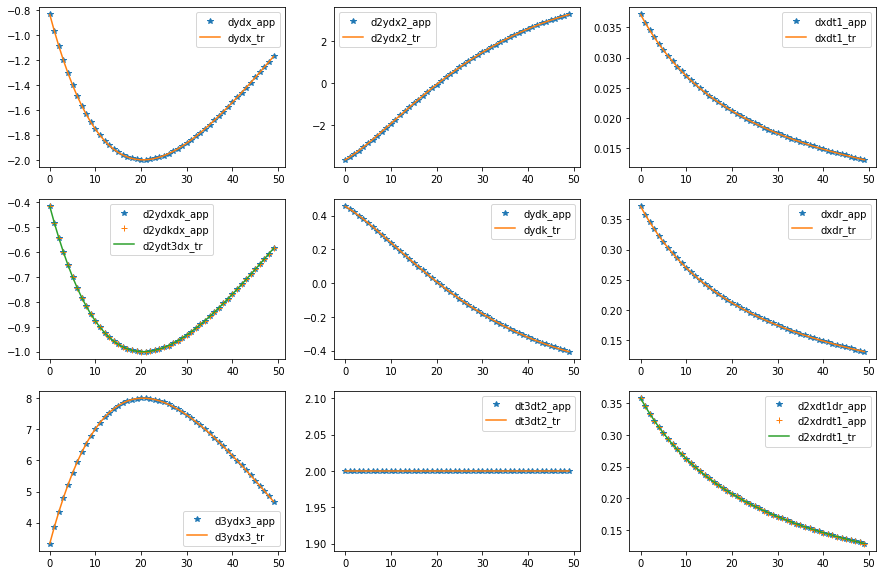

In [12]:
plot_res(result_saver)

<a id='reference'></a>

### References ###
[1. https://en.wikipedia.org/wiki/Automatic_differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation)<br>
[2. Neidinger R D, Introduction to Automatic Differentiation and MATLAB Object-Oriented Programming   (2010)](https://doi.org/10.1137/080743627)<br>
[3. https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html)<br>